# validation & prediction with implicit

## autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## dir setup

In [2]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

## imports

In [4]:
import numpy as np
from datetime import datetime

import pandas as pd
# pd.set_option('max_rows', None)
# pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

from tqdm import tqdm
tqdm.pandas()

import scipy.sparse as sparse
import implicit

from sklearn.metrics import ndcg_score
from sklearn.model_selection import ParameterGrid

import mlflow

import pickle

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## project imports

In [5]:
import sys
sys.path.insert(0, '..')

from src.features import *
from src.models import *

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# validation

In [6]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'

# validation = 0.2 # 0.2: 20% of original train will be test
# keep_train = 0.6  # 0.6: 60% of train for validation

validation = 0.2 
keep_train = 0.1  

# validation = 0.2 
# keep_train = 0.4 
lang = 'pt'

train, test = read_processed(train_fn, test_fn, keep_train = keep_train, validation = validation, lang = lang)

initial train shape: (12412329, 7)
train/test shapes: (992764, 7) (241212, 6)
lang pt


In [7]:
true_fn = 'true.pkl'
true_fp = os.path.join(processed_data_dir, true_fn)
true_df = pd.read_pickle(true_fp)

item_domain_fn = 'item_domain.pkl'
item_domain_fp = os.path.join(processed_data_dir, item_domain_fn)
item_domain = pd.read_pickle(item_domain_fp)
item_domain['lang_category'] = item_domain.category_id.str[:3].replace({'MLM': 'es', 'MLB': 'pt'})
item_domain = item_domain[item_domain.lang_category == lang]
item_domain.drop('lang_category', axis = 1, inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# grid = dict(buy_weight = [50, 100, 200],
#             regularization = [0.01, 0.03, 0.1, 0.3],
#             iterations = [10, 15, 20],
#             factors = [32, 64, 128],
#             alpha_val = [50, 100, 200])

# grid = dict(buy_weight = [200],
#             regularization = [0.01, 0.1],
#             iterations = [10, 15],
#             factors = [128],
#             alpha_val = [200])

# grid = dict(buy_weight = [100, 200],
#             regularization = [0.01],
#             iterations = [15],
#             factors = [768],
#             alpha_val = [200])

grid = dict(buy_weight = [200],
            regularization = [0.01],
            iterations = [15],
            factors = [768],
            alpha_val = [200])

grid = dict(buy_weight = [400],
            regularization = [0.001, 0.01, 0.03],
            iterations = [10, 20, 30],
            factors = [768],
            alpha_val = [400])

grid = dict(buy_weight = [400, 600],
            extra_weight = [50, 100],
            regularization = [0.01],
            iterations = [15],
            factors = [512],
            alpha_val = [600])

grid = dict(buy_weight = [400],
            extra_weight = [200],
            regularization = [0.01],
            iterations = [15],
            factors = [512, 768, 1024],
            alpha_val = [400])

grid

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'buy_weight': [400],
 'extra_weight': [200],
 'regularization': [0.01],
 'iterations': [15],
 'factors': [512, 768, 1024],
 'alpha_val': [400]}

In [9]:
len(list(ParameterGrid(grid))) * 15

45

In [10]:
train

,seq,item_bought,event_info,event_timestamp,event_type,time_diff,lang_seq
42,270127,NaN,1070500,2019-09-30 17:10:59,view,NaN,pt
43,270127,78678.0,NaN,NaT,buy,NaN,pt
112,197616,NaN,GUITARRA EPIPHONE LES PAUL CUSTOM PRO ALPINE,2019-10-10 20:16:21,search,NaN,pt
113,197616,680657.0,NaN,NaT,buy,NaN,pt
120,69509,NaN,236561,2019-10-09 15:30:27,view,NaN,pt
...,...,...,...,...,...,...,...
12403602,8737,NaN,BRINQUEDOS MENINAS,2019-10-02 06:22:53,search,18.0,pt
12403603,8737,NaN,BRINQUEDOS MENINAS,2019-10-02 06:23:10,search,17.0,pt
12403604,8737,NaN,BRINQUEDOS MENINAS,2019-10-02 06:23:21,search,11.0,pt
12403605,8737,NaN,BRINQUEDOS MENINAS,2019-10-02 06:23:34,search,13.0,pt


In [ ]:
mlflow.set_experiment('gcp test 1')

for param in ParameterGrid(grid):
    print(param)
    with mlflow.start_run() as run:
        print("MLflow:")
        print("  run_id:",run.info.run_id)
        print("  experiment_id:",run.info.experiment_id)
        
        test_offset, test_shifted_seq_vals, train_test = join_prepare_train_test(train, test, **param)
        model, seq_map, event_info_map, sparse_user_item = fit_implicit_model(train_test, **param)
        pred = predict_implicit_model(model, sparse_user_item, 
                                      seq_map, event_info_map, test_shifted_seq_vals, 
                                      10, test_offset, 
                                      validation = True, true_df = true_df, item_domain = item_domain)
        
        mlflow.log_param('val_keep', {'v': validation, 'k': keep_train})
        mlflow.log_param('lang', lang)
        mlflow.log_param('exp_decay_alpha', 0.03)
        
        pred_fn = 'pred__' + '__'.join([k + '_' + str(v) for k, v in param.items()]) + '.csv'
        pred_fp = os.path.join(cv_dir, pred_fn)
        pred.to_csv(pred_fp)
        
        mlflow.log_params(param)
        # mlflow.log_artifact(pred_fp)
        
        mean_ndcg = pred.ndcg.mean()
        ndcg_larger_than_zero = (pred.ndcg > 0).mean()
        
        print('mean ndcg:', mean_ndcg)
        print('ndcg > 0:', ndcg_larger_than_zero)
        
        mlflow.log_metric('mean_ndcg', mean_ndcg)
        mlflow.log_metric('ndcg_gt_0', ndcg_larger_than_zero)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'alpha_val': 400, 'buy_weight': 400, 'extra_weight': 200, 'factors': 512, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: 10b121d0156747c3922110eb6dc060f0
  experiment_id: 1


  0%|          | 0/6613 [00:00<?, ?it/s]

100%|██████████| 6613/6613 [01:06<00:00, 99.27it/s] 


mean ndcg: 0.42580902757805356
ndcg > 0: 0.5354604566762438
{'alpha_val': 400, 'buy_weight': 400, 'extra_weight': 200, 'factors': 768, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: fb2783ae04fd4386bbf66e71c2c01d07
  experiment_id: 1


100%|██████████| 6613/6613 [01:25<00:00, 77.50it/s]


mean ndcg: 0.4240684965249333
ndcg > 0: 0.5327385452895811
{'alpha_val': 400, 'buy_weight': 400, 'extra_weight': 200, 'factors': 1024, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: 6a1af24158da415691767d8638bee956
  experiment_id: 1


_____

# a prediction

In [6]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'

lang = 'pt'

train, test = read_processed(train_fn, test_fn, lang = lang)

lang pt


In [7]:
# true_fn = 'true.pkl'
# true_fp = os.path.join(processed_data_dir, true_fn)
# true_df = pd.read_pickle(true_fp)

# item_data_fn = 'item_data.jl.gz'
# item_data = pd.read_json(os.path.join(raw_data_dir, item_data_fn), lines=True)
# item_domain = item_data[['item_id', 'domain_id']]

In [8]:
runs = pd.read_csv('/Users/hitoshinagano/Downloads/runs.csv')
param = runs.sort_values('mean_ndcg', ascending = False).loc[3].to_dict()
param

{'Run ID': '3baaf1a523c040bb81a7696a51b503d2',
 'Name': nan,
 'Source Type': 'LOCAL',
 'Source Name': '/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py',
 'User': 'hitoshinagano',
 'Status': 'FINISHED',
 'alpha_val': 800,
 'buy_weight': 800,
 'exp_decay_alpha': 0.03,
 'extra_weight': 200.0,
 'factors': 512,
 'iterations': 15,
 'lang': 'pt',
 'regularization': 0.01,
 'val_keep': "{'v': 0.2, 'k': 0.4}",
 'mean_ndcg': 0.4337012364037939,
 'ndcg_gt_0': 0.5385629780339851}

In [9]:
test_offset, test_shifted_seq_vals, train_test = join_prepare_train_test(train, test, **param)

In [10]:
model, seq_map, event_info_map, sparse_user_item = fit_implicit_model(train_test, **param)

In [11]:
pred = predict_implicit_model(model, sparse_user_item, 
                              seq_map, event_info_map, test_shifted_seq_vals, 
                              10, test_offset, 
                              validation = False, true_df = None, item_domain = None)

100%|██████████| 142105/142105 [6:21:24<00:00,  6.21it/s]  


#### saving preliminary pred (no imputation and with top scores)

In [12]:
pred_9_fn = lang + '_for_pred_9_implicit.csv'
pred_9_fp = os.path.join(reports_dir, pred_9_fn)
pred.to_csv(pred_9_fp)

In [16]:
pred

,0,1,2,3,4,5,6,7,8,9,top_score
2,1986443.0,167018.0,283306.0,1425647.0,1362449.0,1614538.0,1219935.0,1660615.0,991246.0,539599.0,0.999214
18,865108.0,103123.0,1236596.0,1595726.0,2094573.0,922135.0,897309.0,597830.0,1685016.0,94208.0,0.975279
25,1993945.0,200370.0,1079823.0,1332505.0,183119.0,584351.0,377191.0,310389.0,470332.0,1617403.0,0.954299
31,1449676.0,1223161.0,196897.0,618213.0,406683.0,1589609.0,1083014.0,313485.0,1651683.0,1476002.0,1.022271
43,1516616.0,820462.0,354989.0,1783895.0,978651.0,1489658.0,182971.0,1663875.0,86113.0,938927.0,0.920012
...,...,...,...,...,...,...,...,...,...,...,...
177032,1303554.0,641327.0,212469.0,38857.0,153972.0,1800653.0,652921.0,1438163.0,1662703.0,836208.0,0.984048
177043,1068648.0,1380223.0,211696.0,137522.0,210245.0,1294510.0,107802.0,1306245.0,711862.0,1945320.0,0.870427
177052,467427.0,1114800.0,115596.0,1946789.0,2020215.0,2032781.0,2074404.0,1902728.0,975089.0,2075982.0,0.968937
177057,1329161.0,1360112.0,346969.0,1450837.0,1303928.0,1986828.0,821446.0,1095197.0,1559667.0,2055370.0,0.656464


----

#### exploring pred

<AxesSubplot:ylabel='Frequency'>

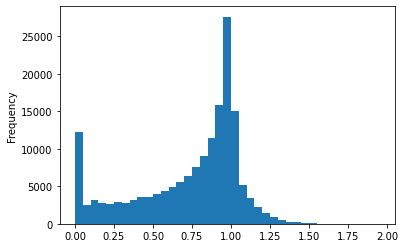

In [21]:
pred.top_score.plot(kind = 'hist', bins = np.arange(0, 2, 0.05))

In [35]:
pred

,0,1,2,3,4,5,6,7,8,9,top_score
0,1572239,1194894,1717880,1300048,1006988,341077,398330,1856280,1326593,794338,0.923182
1,943786,849692,1676401,1056120,416551,937449,1180937,80018,495680,1184491,0.980219
2,731397,1986443,1706245,167018,283306,722653,438010,2015578,1162105,1322369,0.361114
4,1398419,1465133,1114720,1983750,702406,19910,1784740,63682,8478,819461,0.406496
5,1950320,1412311,553430,758537,1683191,1094798,769817,236682,6328,74407,0.944184
...,...,...,...,...,...,...,...,...,...,...,...
177065,23903,624249,602671,1076204,1805356,1251230,1656985,184980,2022473,763171,0.000233
177066,69447,716822,1328443,161963,1651522,1328997,780726,717106,1859462,459697,0.563402
177067,1550304,1426798,273237,1395589,2033823,460028,1839331,1576126,289602,136713,1.078995
177068,1116998,1197876,517435,1396359,273725,1803169,662857,1575734,1565340,745928,0.226957


#### adapting pred to submission format

In [36]:
pred.drop('top_score', axis = 1, inplace = True)

In [37]:
unique_seqs_test = test.seq.unique().shape[0] #177070

In [38]:
pred = pred.reindex(index = range(unique_seqs_test))

In [39]:
top_sellers = list(train[train.event_type.isnull()].item_bought.value_counts().head(10).index.astype(int))

In [40]:
pred[pred[0].isnull()] = top_sellers

In [42]:
pred_6_fn = 'pred_6_implicit.csv'
pred_6_fp = os.path.join(reports_dir, pred_6_fn)
pred.to_csv(pred_6_fp, header = None, index = None)

#### saving implicit ALS model (pkl)
all latent factors included in model

In [50]:
model_6_fn = 'model_6_implicit.pkl'
model_6_fp = os.path.join(models_dir, model_6_fn)
with open(model_6_fp, 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

#### saving item factors (txt)
vector ordered by event_info_id (see event_info_map for a map)

In [121]:
item_factors_6_fn = 'item_factors_6.txt'
item_factors_6_fp = os.path.join(models_dir, item_factors_6_fn)

with open(item_factors_6_fp, 'w') as f:
    for vec in tqdm(model.item_factors):
        f.write('{}\n'.format(' '.join(['{:e}'.format(item) for item in vec])))

100%|██████████| 2101536/2101536 [23:08<00:00, 1513.19it/s]


#### saving event_info_map (pkl)
need to convert event_info (original from meli) into event_info_id (used in implicit)

In [124]:
event_info_map_fn = 'event_info_map.pkl'
event_info_map_fp = os.path.join(models_dir, event_info_map_fn)
event_info_map.to_pickle(event_info_map_fp)

#### testing loading implicit ALS model

In [125]:
model_6_fn = 'model_6_implicit.pkl'
model_6_fp = os.path.join(models_dir, model_6_fn)
with open(model_6_fp, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    model_2 = pickle.load(f)

____

# refactor tests

In [52]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'
train, test = read_processed(train_fn, test_fn)

In [53]:
true_fn = 'true.pkl'
true_fp = os.path.join(processed_data_dir, true_fn)
true_df = pd.read_pickle(true_fp)

item_data_fn = 'item_data.jl.gz'
item_data = pd.read_json(os.path.join(raw_data_dir, item_data_fn), lines=True)
item_domain = item_data[['item_id', 'domain_id']]

In [54]:
# validation = 0.2 # 0.2: 20% of original train will be test
# keep_train = 0.6  # 0.6: 60% of train for validation

validation = 0.2 
keep_train = 0.2  

# validation = 0.2 
# keep_train = 0.4 

if validation:
    train_red, test_red = shrink_and_split(train, keep_train = keep_train, validation = validation)

train shape: (12412329, 6)
train/test shapes: (1982990, 6) (483928, 5)


In [55]:
# grid = dict(buy_weight = [50, 100, 200],
#             regularization = [0.01, 0.03, 0.1, 0.3],
#             iterations = [10, 15, 20],
#             factors = [32, 64, 128],
#             alpha_val = [50, 100, 200])

grid = dict(buy_weight = [200],
            regularization = [0.01, 0.1],
            iterations = [10, 15],
            factors = [128],
            alpha_val = [200])



# grid = dict(buy_weight = [100, 200],
#             regularization = [0.01],
#             iterations = [15],
#             factors = [768],
#             alpha_val = [200])


grid = dict(buy_weight = [200],
            regularization = [0.01, 0.1],
            iterations = [10, 15],
            factors = [128],
            alpha_val = [200], 
            old_sessions_threshold = [1,3,5,7]
            )

grid

{'buy_weight': [200],
 'regularization': [0.01, 0.1],
 'iterations': [10, 15],
 'factors': [128],
 'alpha_val': [200],
 'old_sessions_threshold': [1, 3, 5, 7]}

In [57]:
len(list(ParameterGrid(grid))) * 2

32

In [58]:
def cut_old_sessions(df_train_a, df_test_a, old_sessions_threshold = None, **kwargs):
    
    # print(old_sessions_threshold)
    # print(kwargs)
    
    eight_hours = 60 * 60 * 8
    
    df_train = df_train_a.copy()
    df_test  = df_test_a.copy()
    
    print('train shape:', df_train.shape)
    print('test shape :', df_test.shape)
    
    df_train['session'] = df_train.time_diff > eight_hours
    df_train = df_train.loc[::-1]
    df_train['session'] = df_train.groupby('seq').session.cumsum()
    df_train = df_train.loc[::-1]
    df_train = df_train[df_train.session < old_sessions_threshold]
    df_train.drop(columns = 'session', inplace = True)
    
    df_test['session'] = df_test.time_diff > eight_hours
    df_test = df_test.loc[::-1]
    df_test['session'] = df_test.groupby('seq').session.cumsum()
    df_test = df_test.loc[::-1]
    df_test = df_test[df_test.session < old_sessions_threshold]
    df_test.drop(columns = 'session', inplace = True)

    print('train shape:', df_train.shape)
    print('test shape :', df_test.shape)
    
    return df_train, df_test


In [59]:
tr, tt = cut_old_sessions(train_red, test_red, **p)

1
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (953930, 6)
test shape : (223233, 5)


In [60]:
mlflow.set_experiment('test refactor')

for param in ParameterGrid(grid):
    print(param)
    with mlflow.start_run() as run:
        print("MLflow:")
        print("  run_id:",run.info.run_id)
        print("  experiment_id:",run.info.experiment_id)
        
        train_old_cut, test_old_cut = cut_old_sessions(train_red, test_red, **param)
        
        test_offset, test_shifted_seq_vals, train_test = join_prepare_train_test(train_old_cut, test_old_cut, **param)
        model, seq_map, event_info_map, sparse_user_item = fit_implicit_model(train_test, **param)
        pred = predict_implicit_model(model, sparse_user_item, 
                                      seq_map, event_info_map, test_shifted_seq_vals, 
                                      10, test_offset, 
                                      validation = True, true_df = true_df, item_domain = item_domain)
        
        mlflow.log_param('val_keep', {'v': validation, 'k': keep_train})
        
        pred_fn = 'pred__' + '__'.join([k + '_' + str(v) for k, v in param.items()]) + '.csv'
        pred_fp = os.path.join(cv_dir, pred_fn)
        pred.to_csv(pred_fp)
        
        mlflow.log_params(param)
        mlflow.log_artifact(pred_fp)
        
        mean_ndcg = pred.ndcg.mean()
        ndcg_larger_than_zero = (pred.ndcg > 0).mean()
        
        print('mean ndcg:', mean_ndcg)
        print('ndcg > 0:', ndcg_larger_than_zero)
        
        mlflow.log_metric('mean_ndcg', mean_ndcg)
        mlflow.log_metric('ndcg_gt_0', ndcg_larger_than_zero)


{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 1, 'regularization': 0.01}
MLflow:
  run_id: cb05820c700d4af48d22bb766d0ff9a3
  experiment_id: 3
1
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (953930, 6)
test shape : (223233, 5)


  0%|          | 14/13742 [00:00<01:40, 136.08it/s]

100%|██████████| 13742/13742 [02:21<00:00, 97.33it/s] 


mean ndcg: 0.3739206671936475
ndcg > 0: 0.45750254693639936
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 1, 'regularization': 0.1}
MLflow:
  run_id: 9251afbe75e14eb18b44ffc96d642258
  experiment_id: 3
1
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (953930, 6)
test shape : (223233, 5)


  0%|          | 13/13742 [00:00<01:53, 121.19it/s]

100%|██████████| 13742/13742 [02:11<00:00, 104.66it/s]


mean ndcg: 0.3713664873349885
ndcg > 0: 0.4501528161839616
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 3, 'regularization': 0.01}
MLflow:
  run_id: dcca48bf9eee4abf9c8525948bf1b9eb
  experiment_id: 3
3
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1751803, 6)
test shape : (425617, 5)


  0%|          | 8/15524 [00:00<03:33, 72.79it/s]

100%|██████████| 15524/15524 [04:25<00:00, 58.54it/s]


mean ndcg: 0.3911240151790666
ndcg > 0: 0.48924246328265913
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 3, 'regularization': 0.1}
MLflow:
  run_id: 68dc3f5cbf9444df89ee4257d6b80373
  experiment_id: 3
3
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1751803, 6)
test shape : (425617, 5)


  0%|          | 8/15524 [00:00<03:15, 79.36it/s]

100%|██████████| 15524/15524 [04:11<00:00, 61.82it/s]


mean ndcg: 0.39306612762622384
ndcg > 0: 0.4868590569440866
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 5, 'regularization': 0.01}
MLflow:
  run_id: 1bf442b91611476eb6a0ff187339cfd8
  experiment_id: 3
5
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1940978, 6)
test shape : (472083, 5)


  0%|          | 8/15533 [00:00<03:41, 70.06it/s]

100%|██████████| 15533/15533 [04:34<00:00, 56.56it/s]


mean ndcg: 0.3923225046042376
ndcg > 0: 0.4932080087555527
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 5, 'regularization': 0.1}
MLflow:
  run_id: e8883903a4bd4a9b986e27d404d0da00
  experiment_id: 3
5
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1940978, 6)
test shape : (472083, 5)


  0%|          | 7/15533 [00:00<03:49, 67.55it/s]

100%|██████████| 15533/15533 [04:44<00:00, 54.65it/s]


mean ndcg: 0.39435590701779066
ndcg > 0: 0.49307925062769586
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 7, 'regularization': 0.01}
MLflow:
  run_id: 34ae0ffb938d4d36bb4bbe26fd92728a
  experiment_id: 3
7
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1977343, 6)
test shape : (482265, 5)


  0%|          | 7/15533 [00:00<04:01, 64.26it/s]

100%|██████████| 15533/15533 [04:59<00:00, 51.86it/s]


mean ndcg: 0.3917381115926225
ndcg > 0: 0.49307925062769586
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'old_sessions_threshold': 7, 'regularization': 0.1}
MLflow:
  run_id: e564d3f3823d4af3bceabacb18a5a068
  experiment_id: 3
7
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 10, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1977343, 6)
test shape : (482265, 5)


  0%|          | 7/15533 [00:00<03:53, 66.52it/s]

100%|██████████| 15533/15533 [04:56<00:00, 52.31it/s]


mean ndcg: 0.39333982958237246
ndcg > 0: 0.4937874203309084
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 1, 'regularization': 0.01}
MLflow:
  run_id: 734d45ee256d4ad0b37d4153fbc87de1
  experiment_id: 3
1
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (953930, 6)
test shape : (223233, 5)


  0%|          | 12/13742 [00:00<02:01, 113.40it/s]

100%|██████████| 13742/13742 [02:12<00:00, 103.84it/s]


mean ndcg: 0.36810798533225203
ndcg > 0: 0.4529908310289623
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 1, 'regularization': 0.1}
MLflow:
  run_id: fdc3367af85847148347711965f3cf5f
  experiment_id: 3
1
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (953930, 6)
test shape : (223233, 5)


  0%|          | 16/13742 [00:00<01:29, 153.10it/s]

100%|██████████| 13742/13742 [01:47<00:00, 128.12it/s]


mean ndcg: 0.3661238964049067
ndcg > 0: 0.4453500218308834
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 3, 'regularization': 0.01}
MLflow:
  run_id: 98425f6c332c4524a0d55a607a855e64
  experiment_id: 3
3
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1751803, 6)
test shape : (425617, 5)


  0%|          | 8/15524 [00:00<03:41, 69.95it/s]

100%|██████████| 15524/15524 [04:27<00:00, 58.09it/s]


mean ndcg: 0.38787273965625385
ndcg > 0: 0.48730997165678946
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 3, 'regularization': 0.1}
MLflow:
  run_id: 41b2238719be434cabd1c6846bcbec78
  experiment_id: 3
3
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1751803, 6)
test shape : (425617, 5)


  0%|          | 8/15524 [00:00<03:38, 70.88it/s]

100%|██████████| 15524/15524 [04:24<00:00, 58.60it/s]


mean ndcg: 0.3881456239587888
ndcg > 0: 0.48454006699304303
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 5, 'regularization': 0.01}
MLflow:
  run_id: cc7c10bd101b434ead6f52990b7e1468
  experiment_id: 3
5
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1940978, 6)
test shape : (472083, 5)


  0%|          | 8/15533 [00:00<03:53, 66.51it/s]

100%|██████████| 15533/15533 [04:33<00:00, 56.75it/s]


mean ndcg: 0.3887070462369265
ndcg > 0: 0.4907616043262731
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 5, 'regularization': 0.1}
MLflow:
  run_id: 5d547cce07184b82a145bd03e77cd0f4
  experiment_id: 3
5
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1940978, 6)
test shape : (472083, 5)


  0%|          | 8/15533 [00:00<03:47, 68.37it/s]

100%|██████████| 15533/15533 [04:39<00:00, 55.56it/s]


mean ndcg: 0.38989531548763784
ndcg > 0: 0.4897315393034185
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 7, 'regularization': 0.01}
MLflow:
  run_id: d2f35467c8824723966643a0f16a696f
  experiment_id: 3
7
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.01}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1977343, 6)
test shape : (482265, 5)


  0%|          | 7/15533 [00:00<04:17, 60.32it/s]

100%|██████████| 15533/15533 [04:53<00:00, 53.01it/s]


mean ndcg: 0.3876895231487981
ndcg > 0: 0.488701474280564
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'old_sessions_threshold': 7, 'regularization': 0.1}
MLflow:
  run_id: 5112460411954cafa5e326c8c22a4636
  experiment_id: 3
7
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.1}
train shape: (1982990, 6)
test shape : (483928, 5)
train shape: (1977343, 6)
test shape : (482265, 5)


  0%|          | 7/15533 [00:00<04:06, 62.87it/s]

100%|██████████| 15533/15533 [05:02<00:00, 51.42it/s]


mean ndcg: 0.38938247899481226
ndcg > 0: 0.48863709521663556
